In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
folders = [
    r'./notMNIST_small/A/',
    r'./notMNIST_small/B/',
    r'./notMNIST_small/C/',
    r'./notMNIST_small/D/',
    r'./notMNIST_small/E/',
    r'./notMNIST_small/F/',
    r'./notMNIST_small/G/',
    r'./notMNIST_small/H/',
    r'./notMNIST_small/I/',
    r'./notMNIST_small/J/'

]

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

X_datasets = list()
Y_datasets = list()
for idx in range(len(folders)):
    folder = folders[idx] 
    X_datasets.append(load_letter(folder, 1800))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders)))
    labels[:,idx] = 1
    Y_datasets.append(labels)
    

./notMNIST_small/A/
Could not read: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png : cannot identify image file './notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png' - it's ok, skipping.


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Full dataset tensor: (1872, 28, 28)
Mean: -0.132626
Standard deviation: 0.445128
./notMNIST_small/B/
Full dataset tensor: (1873, 28, 28)
Mean: 0.00535608
Standard deviation: 0.457115
./notMNIST_small/C/
Full dataset tensor: (1873, 28, 28)
Mean: -0.141521
Standard deviation: 0.44269
./notMNIST_small/D/
Full dataset tensor: (1873, 28, 28)
Mean: -0.0492167
Standard deviation: 0.459759
./notMNIST_small/E/
Full dataset tensor: (1873, 28, 28)
Mean: -0.0599148
Standard deviation: 0.45735
./notMNIST_small/F/
Could not read: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png : cannot identify image file './notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png' - it's ok, skipping.
Full dataset tensor: (1872, 28, 28)
Mean: -0.118185
Standard deviation: 0.452279
./notMNIST_small/G/
Full dataset tensor: (1872, 28, 28)
Mean: -0.0925503
Standard deviation: 0.449006
./notMNIST_small/H/
Full dataset tensor: (1872, 28, 28)
Mean: -0.0586893
Standard deviation: 0.458759
./notMNIST_small/I/
F

Total samples number: (18724, 28, 28)
Samples for tests: 4681
Samples for trains: 14043


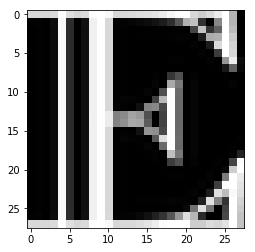

In [3]:
from sklearn.model_selection import train_test_split

X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:",X_datasets2.shape)
X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:",Y_tests.shape[0])
print("Samples for trains:",Y_trains.shape[0])
plt.imshow(X_tests[0],cmap='gray')

In [4]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Reshape,Conv2D,Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='./weights.net', verbose=1, save_best_only=True),
    
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]
print((X_trains[0].shape[0],X_trains[0].shape[1]))
print(Y_trains[0].shape[0])
# create model
model = Sequential()
model.add(Reshape((X_trains[0].shape[0],X_trains[0].shape[1], 1), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Conv2D(48,(3,3),activation='relu',input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Flatten())
model.add(Dense(int(input_dim * 0.15), input_shape = (input_dim,), init='uniform', activation='relu'))
# model.add(Dense(int(input_dim * 0.25), init='uniform', activation='relu'))
model.add(Dense(Y_trains[0].shape[0],init='uniform', name="output"))
model.add(Activation('softmax', name="softmax"))
model.summary()

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_trains, 
          Y_trains, 
          epochs=50, 
          batch_size=10, 
          verbose=2, 
          validation_split=0.25,
          callbacks=callbacks)
# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size=32, verbose=1, sample_weight=None)
# round predictions
print(results)

Using TensorFlow backend.
/root/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


(28, 28)
10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 48)        480       
_________________________________________________________________
flatten_1 (Flatten)          (None, 32448)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 117)               3796533   
_________________________________________________________________
output (Dense)               (None, 10)                1180      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total params: 3,798,193
Trainable params: 3,798,193
Non-trainable params: 0
______________________________________________________

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(117, input_shape=(784,), activation="relu", kernel_initializer="uniform")`
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, name="output", kernel_initializer="uniform")`


Train on 10532 samples, validate on 3511 samples
Epoch 1/50
Epoch 00001: val_loss improved from inf to 0.31304, saving model to ./weights.net
 - 75s - loss: 0.4499 - acc: 0.8712 - val_loss: 0.3130 - val_acc: 0.9043
Epoch 2/50
Epoch 00002: val_loss improved from 0.31304 to 0.30815, saving model to ./weights.net
 - 73s - loss: 0.2277 - acc: 0.9309 - val_loss: 0.3082 - val_acc: 0.9066
Epoch 3/50
Epoch 00003: val_loss improved from 0.30815 to 0.29049, saving model to ./weights.net
 - 72s - loss: 0.1416 - acc: 0.9554 - val_loss: 0.2905 - val_acc: 0.9137
Epoch 4/50
Epoch 00004: val_loss did not improve
 - 73s - loss: 0.0821 - acc: 0.9747 - val_loss: 0.3417 - val_acc: 0.9140
Epoch 00004: early stopping
4681/4681 [==============================] - 2s 397us/step
[0.32512419845187063, 0.91326639608194926]


406


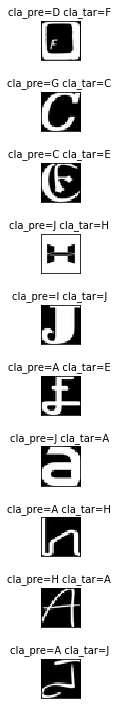

In [5]:
clazzez = ['A','B','C','D','E','F','G','H','I','J']
results = model.predict(X_tests)
errors = list()
for idx in range(len(results)):
    res = results[idx]
    cla_pre = clazzez[np.argmax(res)]
    cla_tar = clazzez[np.argmax(Y_tests[idx])]
    if cla_pre!=cla_tar:
#         print(cla_pre,cla_tar)
        errors.append(idx)
print(len(errors))

problems = 10
fig, axes = plt.subplots(problems, figsize=(10,10))
fig.tight_layout()
for idx in range(problems):
    err = errors[idx]
    cla_pre = clazzez[np.argmax(results[err])]
    cla_tar = clazzez[np.argmax(Y_tests[err])]    
    
    axes[idx].imshow(X_tests[err],cmap='gray')
    axes[idx].set_title("cla_pre=%s cla_tar=%s " % (cla_pre,cla_tar), fontsize=10)
    axes[idx].set_xticks([]) 
    axes[idx].set_yticks([])